In [2]:
import numpy as np
import pandas as pd

# Untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Untuk mengevaluasi performa model
from sklearn.metrics import f1_score, confusion_matrix

# Untuk melakukan ekstraksi data pada suatu kolom
import re 

# Membagi dataset menjadi train dan test set
from sklearn.model_selection import train_test_split

import time
import warnings
warnings.filterwarnings('ignore')

# Set rows ke 100 agar dapat melihat data lebih banyak
pd.set_option('display.max_rows', 100)

In [3]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, Pool

import optuna
from optuna.samplers import TPESampler

### Initial Dataset

In [4]:
X = pd.read_csv("train_features.csv")
y = pd.read_csv("train_labels.csv")
test = pd.read_csv("test_features.csv")
test = test.drop(['ID'], axis=1)
submission_format = pd.read_csv("submission_format.csv")

In [5]:
def summary(df):
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['Duplicate'] = df.duplicated().sum()
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['avg'] = desc['mean'].values
    summ['std dev'] = desc['std'].values
    # summ['top value'] = desc['top'].values
    # summ['Freq'] = desc['freq'].values

    return summ

In [6]:
summary(X).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,76,1899.000000,2000.000000,1967.823946,11.768131
pendidikan,object,189,0,6,nan,nan,nan,nan
status_pernikahan,object,212,0,6,nan,nan,nan,nan
pendapatan,float64,190,0,3622,5073000.000000,332884000.000000,114483170.089606,43460423.969516
jumlah_anak_balita,float64,190,0,3,0.000000,2.000000,0.293080,0.473063
jumlah_anak_remaja,float64,204,0,3,0.000000,2.000000,0.353723,0.493014
terakhir_belanja,float64,172,0,113,0.000000,128.000000,47.231550,27.068512
belanja_buah,float64,181,0,2535,0.000000,396508.000000,59804.239824,74024.976109
belanja_daging,float64,178,0,2951,0.000000,3489675.000000,438574.823853,512042.740059
belanja_ikan,float64,193,0,2627,0.000000,621600.000000,81428.997792,99976.226855


In [7]:
summary(test).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,85,1892.000000,2009.000000,1967.789942,11.808572
pendidikan,object,204,0,6,nan,nan,nan,nan
status_pernikahan,object,182,0,6,nan,nan,nan,nan
pendapatan,float64,203,0,3610,2998899.000000,1305740000.000000,116324904.534716,51051222.459486
jumlah_anak_balita,float64,209,0,3,0.000000,2.000000,0.282904,0.465005
jumlah_anak_remaja,float64,210,0,3,0.000000,2.000000,0.355322,0.496865
terakhir_belanja,float64,201,0,116,0.000000,133.000000,47.181366,26.940287
belanja_buah,float64,186,0,2573,0.000000,408646.000000,61234.083425,76647.590617
belanja_daging,float64,195,0,2943,0.000000,3271191.000000,452848.379796,512320.643716
belanja_ikan,float64,196,0,2660,0.000000,574932.000000,85338.612093,103789.546199


In [8]:
train = pd.concat([X, y], axis=1)

In [9]:
train.sample(10)

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota,jumlah_promosi
2354,1965,Magister,NaN,140201089.0,0.0,0.0,34.0,47620.0,1028239.0,52183.0,77344.0,3.0,2.0,4.0,0.0,NaN,5
3213,1957,Doktor,Rencana Menikah,168919625.0,0.0,0.0,39.0,80765.0,546916.0,88482.0,NaN,0.0,4.0,13.0,0.0,NaN,3
2746,1968,Sarjana,Menikah,152313373.0,0.0,NaN,15.0,268510.0,629808.0,120132.0,105517.0,0.0,10.0,4.0,0.0,NaN,5
1544,1948,Magister,Menikah,136072953.0,0.0,1.0,48.0,6882.0,60334.0,NaN,4650.0,3.0,5.0,5.0,0.0,NaN,4
3037,1984,Magister,Sendiri,84455528.0,0.0,0.0,30.0,NaN,351216.0,113626.0,79959.0,1.0,5.0,8.0,0.0,NaN,6
2378,1958,Sarjana,Menikah,134895969.0,0.0,1.0,18.0,50037.0,425169.0,83386.0,38650.0,3.0,6.0,12.0,0.0,NaN,1
2899,1968,Sarjana,Rencana Menikah,110748000.0,0.0,0.0,77.0,8092.0,145656.0,NaN,16184.0,0.0,3.0,7.0,0.0,2013-05-25,0
702,1972,NaN,Menikah,101938145.0,0.0,0.0,38.0,18146.0,97034.0,68421.0,28368.0,0.0,5.0,2.0,0.0,NaN,4
1347,1966,Magister,Sendiri,97911806.0,0.0,0.0,79.0,172731.0,473171.0,111739.0,89012.0,1.0,8.0,11.0,0.0,NaN,6
3505,1966,Sarjana,Menikah,124881047.0,0.0,NaN,72.0,5235.0,98400.0,3568.0,4758.0,0.0,5.0,5.0,0.0,NaN,4


In [10]:
# train['jumlah_promosi'].value_counts().plot(kind = 'bar')
# plt.ylabel('Percentage')

In [11]:
train['jumlah_promosi'].value_counts()

jumlah_promosi
0    983
5    557
1    515
4    515
3    472
2    389
6    386
Name: count, dtype: int64

In [12]:
train['pembelian_toko'].mean()
# train['total'] = train['pembelian_web'] + train['pembelian_toko'] - train['pembelian_diskon']
# train['total'] = train['jumlah_anak_balita'] + train['jumlah_anak_remaja']

5.76781798245614

In [13]:
print(train['terakhir_belanja'].mean())
salary_by_class = train.groupby('jumlah_promosi')['terakhir_belanja'].mean()
salary_by_class

47.231550068587104


jumlah_promosi
0    49.863780
1    50.236364
2    48.139726
3    52.887912
4    50.639175
5    40.451493
6    33.685083
Name: terakhir_belanja, dtype: float64

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3817 entries, 0 to 3816
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tahun_kelahiran          3817 non-null   int64  
 1   pendidikan               3628 non-null   object 
 2   status_pernikahan        3605 non-null   object 
 3   pendapatan               3627 non-null   float64
 4   jumlah_anak_balita       3627 non-null   float64
 5   jumlah_anak_remaja       3613 non-null   float64
 6   terakhir_belanja         3645 non-null   float64
 7   belanja_buah             3636 non-null   float64
 8   belanja_daging           3639 non-null   float64
 9   belanja_ikan             3624 non-null   float64
 10  belanja_kue              3603 non-null   float64
 11  pembelian_diskon         3639 non-null   float64
 12  pembelian_web            3652 non-null   float64
 13  pembelian_toko           3648 non-null   float64
 14  keluhan                 

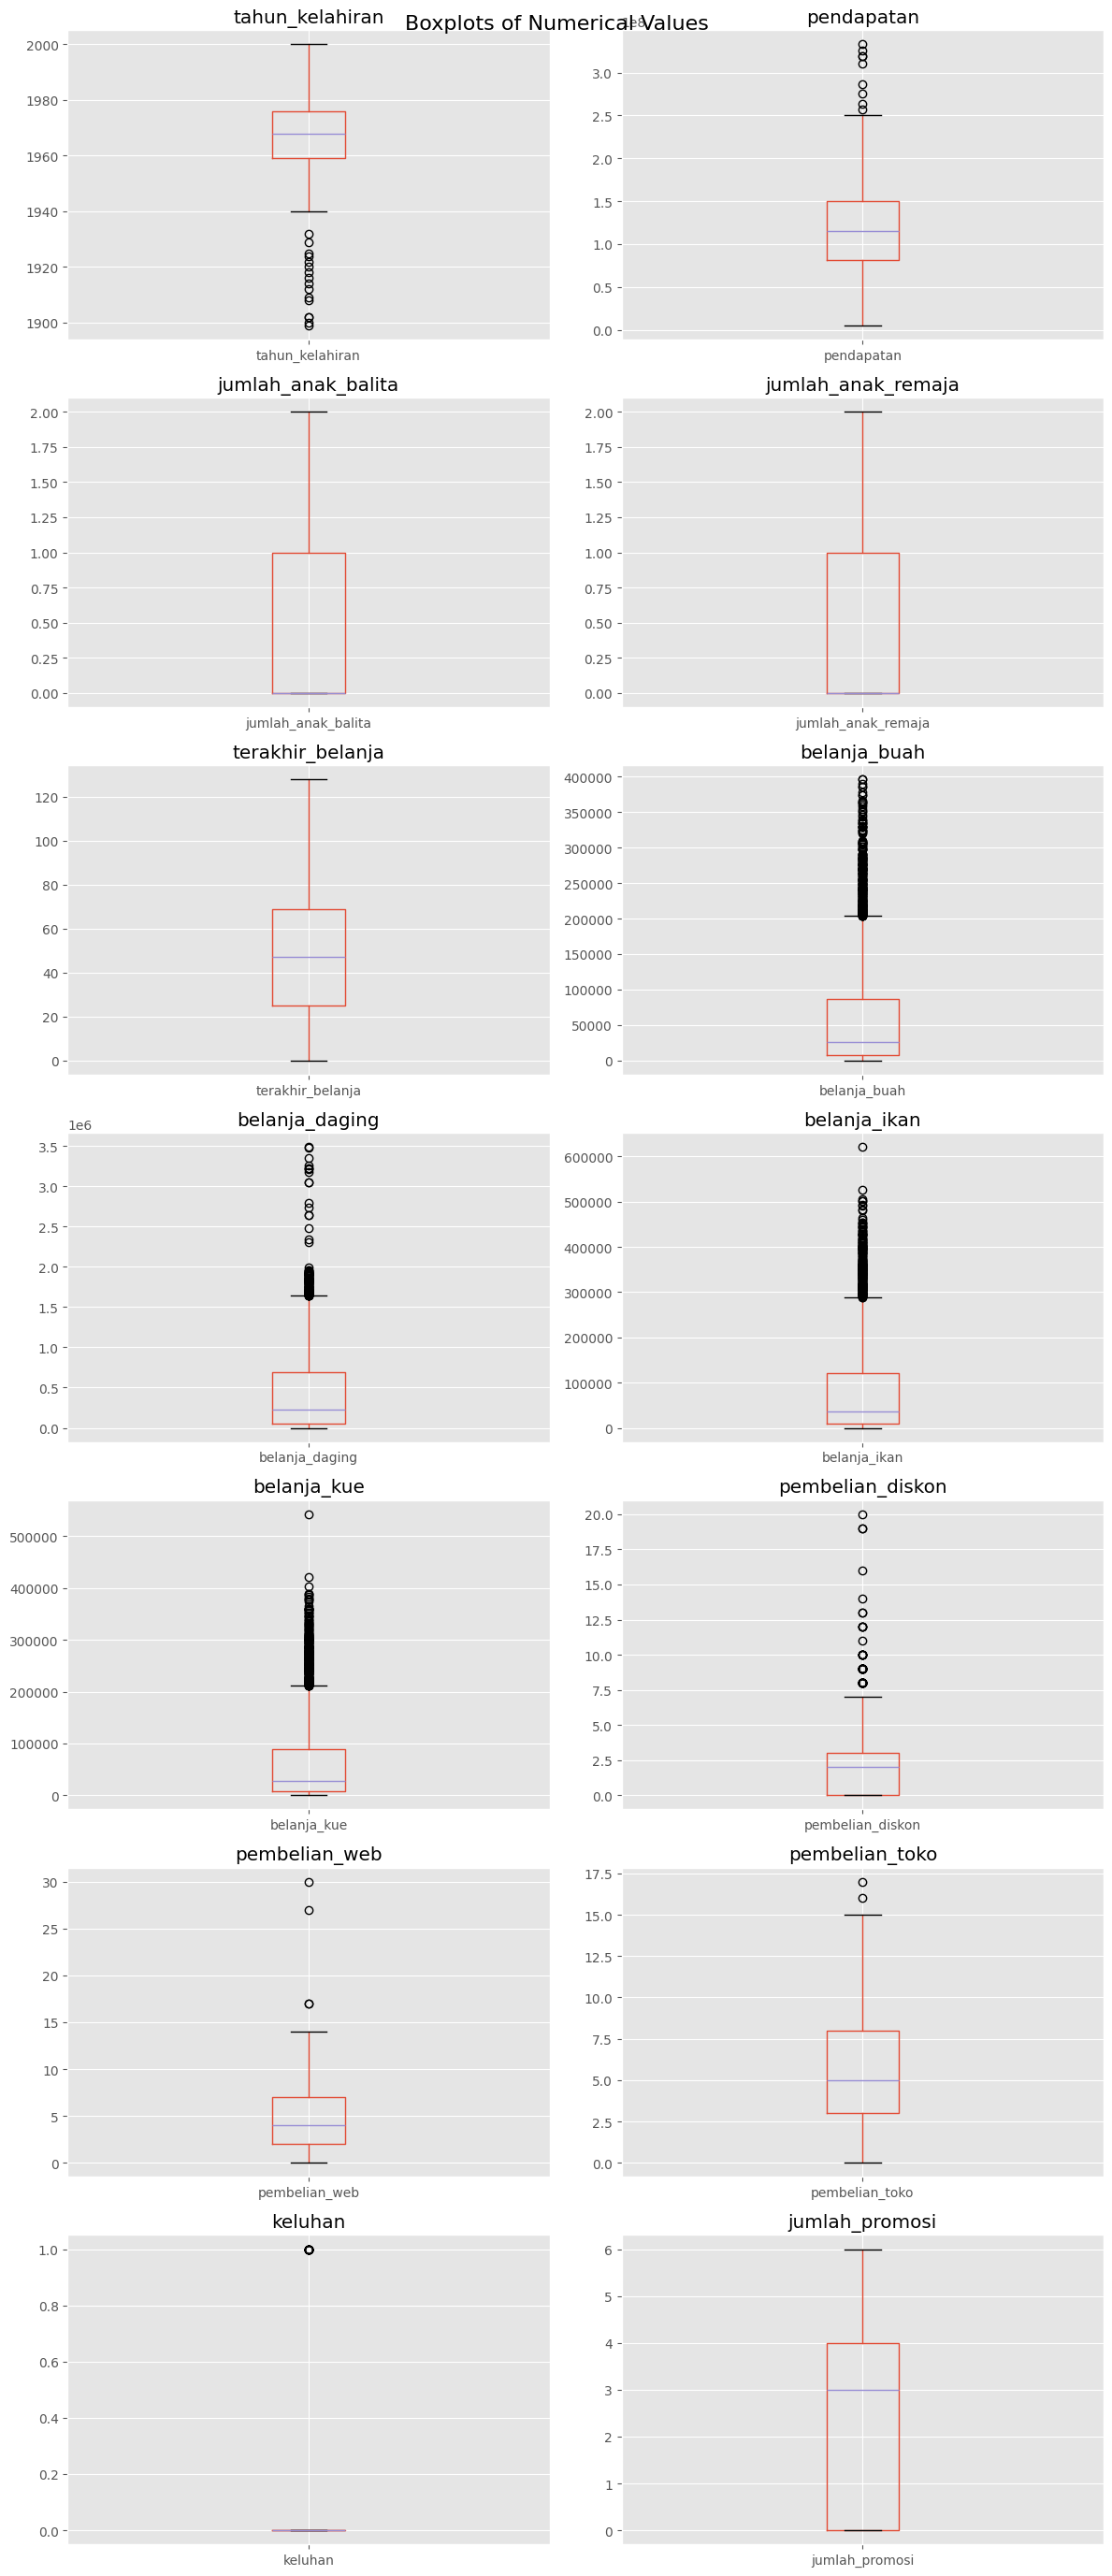

In [15]:
numerical_data = train.select_dtypes(include=[np.number])  # Select numerical columns

num_cols = numerical_data.shape[1]
num_rows = int(np.ceil(num_cols / 2))

fig, axes = plt.subplots(num_rows, 2, figsize=(12, num_rows * 4))
fig.suptitle('Boxplots of Numerical Values', fontsize=16)

for i, column in enumerate(numerical_data.columns):
    ax = axes[i // 2, i % 2] if num_rows > 1 else axes[i % 2]
    numerical_data.boxplot(column=column, ax=ax)
    ax.set_title(column)
    

plt.tight_layout()
plt.show()

In [16]:
table = pd.crosstab(train['status_pernikahan'], train['jumlah_promosi'])
table

jumlah_promosi,0,1,2,3,4,5,6
status_pernikahan,,,,,,,
5,1,0,0,0,0,0,0
Cerai,72,34,16,40,11,16,25
Cerai Mati,16,5,3,10,2,1,3
Menikah,338,170,119,124,146,117,100
Rencana Menikah,238,160,167,176,204,197,129
Sendiri,258,120,59,105,120,192,111


### Preprocessing

In [17]:
def preprocessing(df):
    df = df.drop(['tanggal_menjadi_anggota'], axis=1)
    
    df['pendidikan'] = df['pendidikan'].map({'SMP': 1, 'SMA': 2, 'Sarjana': 3, 'Magister': 4, 'Doktor': 5})
    df['status_pernikahan'] = df['status_pernikahan'].map({'Sendiri': 1, 'Rencana Menikah': 2, 'Menikah': 2, 'Cerai': 1, 'Cerai Mati': 1})
    # df = pd.get_dummies(df, columns=['status_pernikahan'])
    
    # Pemeblian diatas 15 diubah jadi 15
    # df.loc[df['pembelian_web'] > 15, 'pembelian_web'] = 15
    # df.loc[df['pembelian_toko'] > 15, 'pembelian_toko'] = 15
    
    # Fill Null Val dengan interpolate
    df['pendapatan'] = df['pendapatan'].interpolate(method ='pad', limit_direction ='forward')
    df['terakhir_belanja'] = df['terakhir_belanja'].interpolate(method ='pad', limit_direction ='forward')
    df['belanja_buah'] = df['belanja_buah'].interpolate(method ='pad', limit_direction ='forward')
    df['belanja_daging'] = df['belanja_daging'].interpolate(method ='pad', limit_direction ='forward')
    df['belanja_ikan'] = df['belanja_ikan'].interpolate(method ='pad', limit_direction ='forward')
    df['belanja_kue'] = df['belanja_kue'].interpolate(method ='pad', limit_direction ='forward')
    df['pembelian_diskon'] = df['pembelian_diskon'].interpolate(method ='pad', limit_direction ='forward')
    df['pembelian_toko'] = df['pembelian_toko'].interpolate(method ='pad', limit_direction ='forward')
    df['pembelian_web'] = df['pembelian_web'].interpolate(method ='pad', limit_direction ='forward')
    
    # Fill Null Val dengan median
    df = df.fillna(df.median())

    # df = df.drop(['pendidikan','pembelian_diskon'], axis=1)
    
    # Change data type to int64
    numerical_data = df.select_dtypes(include=[np.number])  # Select numerical columns
    for i, column in enumerate(numerical_data.columns):
        df[column] = df[column].astype('int64')

    # Feature Selection
    df = df.drop(['keluhan', 'pendidikan'], axis=1)

    # Feature Engineering
    df['anggota_keluarga'] = df['status_pernikahan'] + df['jumlah_anak_balita'] + df['jumlah_anak_remaja']
    # df['umur'] = 2024 - df['tahun_kelahiran']
    
    df = df.drop(['status_pernikahan', 'jumlah_anak_balita', 'jumlah_anak_remaja'], axis=1)
    
    
    # df['total_belanja'] = df['belanja_buah'] + df['belanja_daging'] + df['belanja_ikan'] + df['belanja_kue']
    # df['rasio_pembelian_diskon'] = df['pembelian_diskon'] / df['total_belanja']
    
    return df

In [18]:
# Preprocess train set
train = preprocessing(train)
summary(train).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,76,1899.000000,2000.000000,1967.823946,11.768131
pendapatan,int64,0,0,3622,5073000.000000,332884000.000000,114502718.265392,43535581.079180
terakhir_belanja,int64,0,0,113,0.000000,128.000000,47.165051,27.038698
belanja_buah,int64,0,0,2535,0.000000,396508.000000,59942.936861,73936.467562
belanja_daging,int64,0,0,2951,0.000000,3489675.000000,437177.892062,510953.244736
belanja_ikan,int64,0,0,2627,0.000000,621600.000000,81472.008908,100224.593805
belanja_kue,int64,0,0,2475,0.000000,542164.000000,62981.860624,78954.662837
pembelian_diskon,int64,0,0,18,0.000000,20.000000,2.126801,2.096382
pembelian_web,int64,0,0,18,0.000000,30.000000,4.425727,2.994982
pembelian_toko,int64,0,0,18,0.000000,17.000000,5.761855,3.214001


In [19]:
# mean_salary_by_class = train.groupby('jumlah_promosi')['pembelian_web'].median()
# mean_salary_by_class

In [20]:
# Preprocess test set
test = preprocessing(test)
summary(test).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,85,1892.000000,2009.000000,1967.789942,11.808572
pendapatan,int64,0,0,3610,2998899.000000,1305740000.000000,116065955.075694,50620219.819494
terakhir_belanja,int64,0,0,116,0.000000,133.000000,47.076742,26.937135
belanja_buah,int64,0,0,2573,0.000000,408646.000000,61269.735726,76725.515769
belanja_daging,int64,0,0,2943,0.000000,3271191.000000,451738.129125,510561.021483
belanja_ikan,int64,0,0,2660,0.000000,574932.000000,85158.235464,103303.662294
belanja_kue,int64,0,0,2526,0.000000,532049.000000,63653.494762,78511.934217
pembelian_diskon,int64,0,0,17,0.000000,17.000000,2.105029,2.122949
pembelian_web,int64,0,0,16,0.000000,27.000000,4.469618,2.931091
pembelian_toko,int64,0,0,18,0.000000,17.000000,5.839707,3.283396


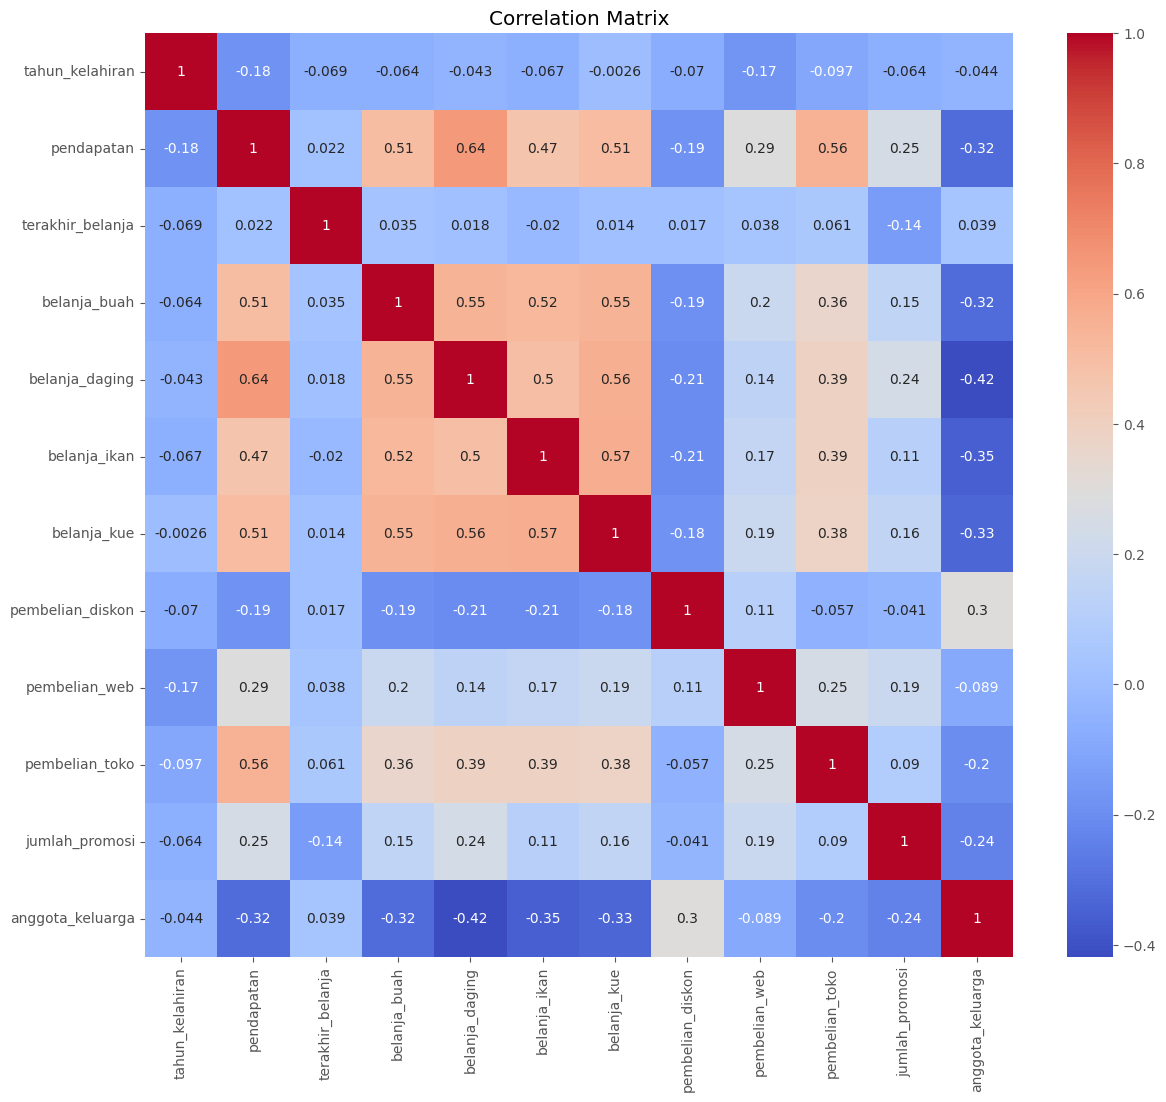

In [21]:
# Menghitung matriks korelasi
corr_matrix = train.corr()

# Membuat plot heatmap 
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.title('Correlation Matrix')
plt.show()

In [22]:
X = train.drop(columns = ['jumlah_promosi'], axis = 1)
y = train['jumlah_promosi']

In [23]:
# from imblearn.under_sampling import RandomUnderSampler

# # undersample
# rus = RandomUnderSampler(random_state=42)
# X, y = rus.fit_resample(X, y)

# # plot the new distribution
# unique, counts = np.unique(y_train_resampled, return_counts=True)
# plt.bar(unique, counts)
# plt.ylabel('Number of Instances')
# plt.show()

In [24]:
from imblearn.over_sampling import SMOTE
# Apply SMOTE oversampling to the training data
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

In [25]:
skf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Optuna

In [28]:
%%time
def objective(trial):
    # Number of trees in random forest
    n_estimators = trial.suggest_int(name="n_estimators", low=100, high=1000)

    # Number of features to consider at every split
    max_features = trial.suggest_int(name="max_features", low=1, high=10)

    # Maximum number of levels in tree
    max_depth = trial.suggest_int(name="max_depth", low=10, high=50)

    # Minimum number of samples required to split a node
    min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=32)

    # Minimum number of samples required at each leaf node
    min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=32)
    
    
    model = ExtraTreesClassifier(n_estimators = n_estimators, criterion = 'log_loss', max_depth =  max_depth,
                                    min_samples_split =  min_samples_split, min_samples_leaf =  min_samples_leaf,
                                    max_features =  max_features, random_state =  1, n_jobs =  -1)
    
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model.fit(X, y)
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='macro')
        f1_scores.append(f1)

    return np.mean(f1_scores)
  
    score = cross_val_score(model, X_train, y_train, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
    return score.mean() 

sampler = TPESampler(seed=42)
study = optuna.create_study(study_name="extra_tree", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=200, show_progress_bar = True)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

    
# optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna.visualization.plot_optimization_history(study)

'''
Number of finished trials:  200
Best trial:
  Value:  0.7771048671944477
  Params: 
    n_estimators: 441
    max_features: 11
    max_depth: 79
    min_samples_split: 3
    min_samples_leaf: 1
CPU times: total: 11min 8s
Wall time: 21min 38s
'''

[I 2024-04-27 01:29:37,361] A new study created in memory with name: extra_tree


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-04-27 01:29:50,500] Trial 0 finished with value: 0.95864873453817 and parameters: {'n_estimators': 437, 'max_features': 10, 'max_depth': 40, 'min_samples_split': 20, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.95864873453817.
[I 2024-04-27 01:29:54,276] Trial 1 finished with value: 0.3931810426320913 and parameters: {'n_estimators': 240, 'max_features': 1, 'max_depth': 45, 'min_samples_split': 20, 'min_samples_leaf': 23}. Best is trial 0 with value: 0.95864873453817.
[I 2024-04-27 01:29:57,942] Trial 2 finished with value: 0.9743943447172967 and parameters: {'n_estimators': 118, 'max_features': 10, 'max_depth': 44, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.9743943447172967.
[I 2024-04-27 01:30:03,892] Trial 3 finished with value: 0.8818635126271636 and parameters: {'n_estimators': 265, 'max_features': 4, 'max_depth': 31, 'min_samples_split': 15, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.9743943447172967.
[I 2024-04-27 0

KeyboardInterrupt: 

### Model

In [31]:
# ExtraTreesClassifier
ET_cv = cross_val_score(ExtraTreesClassifier(n_estimators = 407, max_features = 10, max_depth = 62, min_samples_split = 2,   
                                             min_samples_leaf = 1, criterion = 'log_loss', random_state = 1),
                        X, y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
print(f"The average 10-folds Macro F-Score of the ET is {ET_cv.mean()} \n")

ET_cv = cross_val_score(ExtraTreesClassifier(n_estimators = 403, max_features = 8, max_depth = 38, min_samples_split = 2,
                                            min_samples_leaf = 1, criterion = 'log_loss', random_state = 1),
                        X, y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
print(f"The average 10-folds Macro F-Score of the ET is {ET_cv.mean()} \n")

ET_cv = cross_val_score(ExtraTreesClassifier(n_estimators = 347, max_features = 8, max_depth = 36, min_samples_split = 4,
                                            min_samples_leaf = 1, criterion = 'log_loss', random_state = 1),
                        X, y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
print(f"The average 10-folds Macro F-Score of the ET is {ET_cv.mean()} \n")

ET_cv = cross_val_score(ExtraTreesClassifier(n_estimators = 363, max_features = 8, max_depth = 38, min_samples_split = 3,
                                            min_samples_leaf = 1, criterion = 'log_loss', random_state = 1),
                        X, y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
print(f"The average 10-folds Macro F-Score of the ET is {ET_cv.mean()} \n")

ET_cv = cross_val_score(ExtraTreesClassifier(n_estimators = 118, max_features = 10, max_depth = 44, min_samples_split = 8,
                                            min_samples_leaf = 6, criterion = 'log_loss', random_state = 1),
                        X, y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
print(f"The average 10-folds Macro F-Score of the ET is {ET_cv.mean()} \n")


# # LGBMClassifier
# LGBM_cv = cross_val_score(LGBMClassifier(n_estimators = 2000, reg_alpha = 0.0014394303776950955, reg_lambda = 0.0010085065533368821,
#                                         colsample_bytree = 0.6, subsample = 0.7, learning_rate = 0.02, max_depth = 10, min_child_samples = 13,
#                                         num_leaves = 178, min_data_per_groups = 94, random_state =  1, verbose = -1), 
#                         X, y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
# print(f"The average 10-fold Macro F-Score of the LGBM is {LGBM_cv.mean()} \n")

The average 10-folds Macro F-Score of the ET is 0.8807156485778826 

The average 10-folds Macro F-Score of the ET is 0.8793053145249893 

The average 10-folds Macro F-Score of the ET is 0.8754056952241909 

The average 10-folds Macro F-Score of the ET is 0.8780310505215114 

The average 10-folds Macro F-Score of the ET is 0.8122856501757514 



In [34]:
# model = ExtraTreesClassifier(n_estimators = 543, max_features = 15, max_depth = 44, min_samples_split = 3,
#                                             min_samples_leaf = 1, criterion = 'log_loss', random_state = 1)

# model = ExtraTreesClassifier(n_estimators = 535, max_features = 16, max_depth = 570, min_samples_split = 2,
#                                             min_samples_leaf = 1, criterion = 'log_loss', random_state = 1)

model = ExtraTreesClassifier(n_estimators = 403, max_features = 8, max_depth = 38, min_samples_split = 2,
                                            min_samples_leaf = 1, criterion = 'log_loss', random_state = 1)

model.fit(X, y)
y_pred = model.predict(X_test)
print('F1: ', f1_score(y_test, y_pred, average='macro'))
submission = model.predict(test)

F1:  1.0


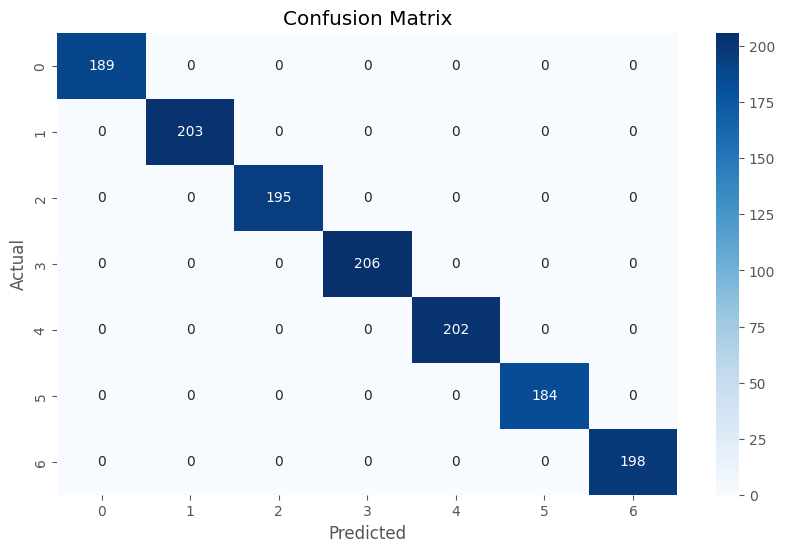

In [35]:
plt.figure(figsize=(10, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import learning_curve

# # Assuming you have your regression model called 'regressor' and your feature matrix 'X' and target variable 'y'

# # Create a function to plot the learning curve
# def plot_learning_curve(estimator, X, y):
#     train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, cv=5,
#                                                           train_sizes=np.linspace(0.1, 1.0, 10))

#     # Calculate the mean and standard deviation of the training scores
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)

#     # Calculate the mean and standard deviation of the validation scores
#     val_scores_mean = np.mean(val_scores, axis=1)
#     val_scores_std = np.std(val_scores, axis=1)

#     # Plot the learning curve
#     plt.figure(figsize=(8, 6))
#     plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
#     plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Validation score")
#     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.2, color="r")
#     plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
#                      val_scores_mean + val_scores_std, alpha=0.2, color="g")
#     plt.xlabel("Training Set Size")
#     plt.ylabel("Score")
#     plt.title("Learning Curve")
#     plt.legend(loc="best")
#     plt.grid(True)
#     plt.show()
    
# plot_learning_curve(model, X, y)

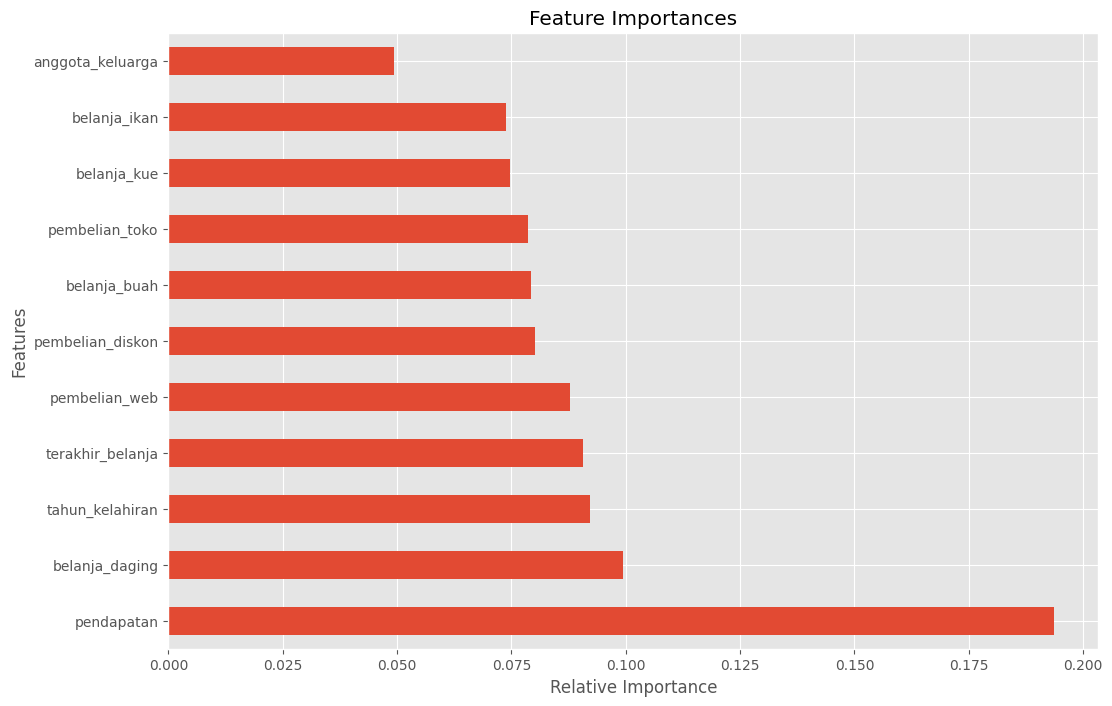

In [36]:
plt.figure(figsize=(12, 8))
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()

In [37]:
submission_format['jumlah_promosi'] = pd.DataFrame(submission)
submission_format.to_csv('submission_v.csv',index = False)
submission_format.value_counts('jumlah_promosi')

jumlah_promosi
0    1012
5     606
4     569
3     475
1     410
6     385
2     361
Name: count, dtype: int64

In [38]:
train.value_counts('jumlah_promosi')

jumlah_promosi
0    983
5    557
1    515
4    515
3    472
2    389
6    386
Name: count, dtype: int64